In [32]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfb = tfp.bijectors
psd_kernels = tfp.math.psd_kernels

num_points = 100


In [33]:
observation_noise_variance = tf.constant(.5,dtype = tf.float64)
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)

In [34]:
observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = (f(observation_index_points) +
                np.random.normal(0., np.sqrt(observation_noise_variance)))

In [50]:
observation_index_points

<tf.Tensor: shape=(50, 1), dtype=float64, numpy=
array([[ 0.70963911],
       [ 0.749232  ],
       [-0.68218638],
       [-0.56681616],
       [-0.65420361],
       [-0.40007069],
       [-0.76921248],
       [-0.84621499],
       [-0.31758621],
       [-0.12140349],
       [ 0.79989864],
       [ 0.88876791],
       [-0.21407094],
       [ 0.67395765],
       [-0.59703293],
       [ 0.229937  ],
       [ 0.27387769],
       [-0.71910823],
       [ 0.07059736],
       [ 0.52447782],
       [-0.87437695],
       [-0.06577385],
       [ 0.11164518],
       [-0.44456858],
       [ 0.91704351],
       [ 0.08140098],
       [-0.91945014],
       [-0.82499217],
       [-0.65909556],
       [-0.59539015],
       [-0.92430554],
       [ 0.56705021],
       [ 0.20903296],
       [ 0.71145552],
       [ 0.34926866],
       [ 0.51852707],
       [ 0.3244425 ],
       [-0.05274445],
       [ 0.99865234],
       [-0.81844205],
       [-0.52720945],
       [ 0.11168381],
       [-0.12393717],
     

In [49]:
observations

<tf.Tensor: shape=(50,), dtype=float64, numpy=
array([-0.0195281 ,  0.07494681, -0.78070357, -0.04015508, -0.62543781,
        0.18667081, -1.00475032, -0.85963555, -0.42761534, -1.38191414,
        0.06325238, -0.22636192, -1.262826  , -0.17876382, -0.24309791,
        0.2491103 , -0.09490912, -0.92855174,  0.18695873, -1.11298534,
       -0.75169055, -1.0672805 ,  0.42882746,  0.33305884, -0.35007356,
        0.26365366, -0.55659782, -0.92572708, -0.65478593, -0.23173984,
       -0.53550042, -0.87552842,  0.37234755, -0.01320854, -0.76301915,
       -1.13896487, -0.55098591, -0.96051935, -0.65507557, -0.94268988,
        0.1831834 ,  0.42898717, -1.38975706, -0.19071306, -0.78014251,
        0.25243885,  0.13257513, -1.10460914,  0.05439951,  0.34551602])>

In [37]:
observations = tf.convert_to_tensor(observations,dtype = tf.float64)

observation_index_points = tf.convert_to_tensor(observation_index_points,dtype = tf.float64)

In [39]:
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

In [40]:
optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss


In [47]:
observation_noise_variance

<TransformedVariable: dtype=float64, shape=[], fn="exp", numpy=2.0199864189824115e-08>

In [45]:
gp.log_prob(observations)

<tf.Tensor: shape=(), dtype=float64, numpy=194.428415370383>

In [41]:
index_points = np.linspace(-1., 1., 100)[..., np.newaxis]
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# First train the model, then draw and plot posterior samples.
for i in range(1000):
  neg_log_likelihood_ = optimize()
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

Step 0: NLL = 912.3095076122613
Step 100: NLL = -32.223517413975344
Step 200: NLL = -46.64756680995157
Step 300: NLL = -68.06686146486432
Step 400: NLL = -100.93716793709542
Step 500: NLL = -146.02090288339298
Step 600: NLL = -183.0220156232226
Step 700: NLL = -191.68041178677797
Step 800: NLL = -193.51248268591692
Step 900: NLL = -194.14784430837148
Final NLL = -194.42886476328184


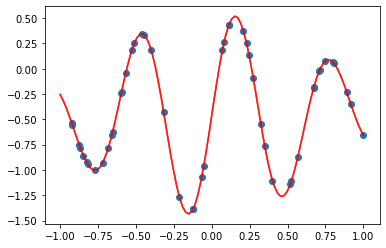

In [42]:
samples = gprm.sample(1).numpy()
# ==> 10 independently drawn, joint samples at `index_points`.

import matplotlib.pyplot as plt
plt.scatter(np.squeeze(observation_index_points), observations)
plt.plot(np.stack([index_points[:, 0]]*10).T, samples.T, c='r', alpha=.2)

In [44]:
with tf.GradientTape() as t:
    t.watch(observations)
    samples = gprm.sample(1)
    print(t.gradient(samples,observations))

tf.Tensor(
[ 1.52355841  1.26866059 -0.52495206  2.53240232 -1.45402674  0.91878931
  8.96382583 -1.66421945  4.72825391  2.01636319  1.39936112  2.99976084
  6.09352272  1.87743935  0.8667598   0.80978662  1.56774306  3.26670964
  2.96224374  2.66411739 -9.19577493  1.45534276  2.18783754  1.18989984
  3.59495992  2.8106555   5.23122948  4.24341991 -1.42106371  0.9672292
 11.2131099   2.56493898  0.67215036  1.5073897   3.00415554  2.68192238
  2.63250629  1.60738092  2.04179758  5.69749718  3.41243147  2.1869218
  2.09421688  1.9001057  -7.72714777  3.24694331  1.0324918   3.25829366
  1.44788721  1.64153266], shape=(50,), dtype=float64)
